In [1]:
import torch
import cupy
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import pytest
import h5py

# Torch Implementation
This is the PyTorch implementation of the Gauss-Seidel solver. We use roll operations instead of relying on nested loops, as desired

In [2]:
def gauss_seidel_torch(f):
    newf = torch.zeros_like(f).cuda()

    newf += torch.roll(f, (0, 1), (0, 1))
    newf += torch.roll(f, (0, -1), (0, 1))
    newf += torch.roll(f, (1, 0), (0, 1))
    newf += torch.roll(f, (-1, 0), (0, 1))

    # Ensure that the edges remain 0
    newf[0,:] = 0
    newf[:,0] = 0
    newf[-1,:] = 0
    newf[:,-1] = 0
    return 0.25*newf

# CuPy Implementation
This is the cupy implementation (very similar to the PyTorch implementation above)

In [3]:
def gauss_seidel_cupy(f):
    newf = cupy.zeros_like(f)

    newf += cupy.roll(f, (0, 1), (0, 1))
    newf += cupy.roll(f, (0, -1), (0, 1))
    newf += cupy.roll(f, (1, 0), (0, 1))
    newf += cupy.roll(f, (-1, 0), (0, 1))

    newf[0,:] = 0
    newf[:,0] = 0
    newf[-1,:] = 0
    newf[:,-1] = 0

    return 0.25 * newf

# Default Implementation
This is a _slightly_ modified version of the default for-loop implementation of the solver provided to us in the assignment handout.
Notice that here, in the nested loops, instead of using `newf` to determine the value of `newf[i, j]`, we are using `f` (the original array)
instead. This helps us parallelize the operation using vectorization (which is visible above), and is the implementation of the **Jacobi numerical scheme**

In [4]:
def gauss_seidel_default(f):
    newf = f.copy()

    for i in range(1,newf.shape[0]-1):
        for j in range(1,newf.shape[1]-1):
            newf[i,j] = (f[i,j+1] + f[i,j-1] +
                                f[i+1,j] + f[i-1,j])

    return newf * 0.25

# Utilities
These are the different utility functions we use to verify correctness of our implementation and for generating plots.

In [5]:
def run_gauss_seidel_torch(func, N, num_iterations):
    # We first generate our starting arrays in numpy and then port them over to a pytorch tensor (in this function)
    # or a cupy array (in the next function)
    # This helps us ensure reproducability of the tests (because of the same seed being and the same generation method).
    np.random.seed(42)
    grid = np.zeros((N, N))
    grid[1:-1, 1:-1] = np.random.rand(N-2, N-2)

    # Port to pytorch tensor before continuing
    grid = torch.tensor(grid).cuda()

    for _ in range(num_iterations):
        grid = func(grid)
    return grid

def run_gauss_seidel_cupy(func, N, num_iterations):
    np.random.seed(42)
    grid = np.zeros((N, N))
    grid[1:-1, 1:-1] = np.random.rand(N-2, N-2)

    # Port to cupy array before continuing
    grid = cupy.asarray(grid)

    for _ in range(num_iterations):
        grid = func(grid)

    # We synchronize to ensure that our code finishes executing on the GPU before going to the next line.
    cupy.cuda.Stream.null.synchronize()
    return grid

def run_gauss_seidel_default(func, N, num_iterations):
    np.random.seed(42)
    grid = np.zeros((N, N))
    grid[1:-1, 1:-1] = np.random.rand(N-2, N-2)

    for _ in range(num_iterations):
        grid = func(grid)
    return grid

def timed(f, *args, **kwargs):
    t0 = timer()
    f(*args, **kwargs)
    t1 = timer()
    return t1 - t0

def run_function_as_experiment(f, func, num_iterations = 100):
    grid_sizes = [2**i for i in range(6, 11)]
    num_runs = 5
    wtimes = np.zeros(len(grid_sizes))

    for _ in range(num_runs):
        wtimes += [timed(f, func, curr_size, num_iterations) for curr_size in grid_sizes]
    wtimes /= num_runs

    print(f"ran {f.__name__}")
    print(f"each grid ran {num_iterations} iterations. ({num_runs} runs)")
    for i, j in zip(grid_sizes, wtimes):
        print(f"Grid: ({i}, {i})\n\truntime: {j}s")
    plt.plot(grid_sizes, wtimes, label=f"{f.__name__}", marker='o')

# Test Verification
This ensures that the optimizations we have made for the PyTorch and Cupy version of the code return similar results when compared to the Jacobi implementation of the default Gauss-Seidel solver provided to us. Note that we are using `np.allclose` in our comparisons instead of a literal/strictest comparison. This is because we observed that for higher number of iterations or for bigger grid sizes, there seem to be some minor differences in the decimal places.

We believe this is because of the different levels of precision in the FLOPS present in Numpy vs Pytorch vs CuPy. Thus, comarpring the **closeness** of the of the PyTorch and CuPy implementations to the one returned by the "default" implementation instead of absolute equality seems like a reasonable approach to us.

In [6]:
def test_grid_diff_sizes(grid_size):

    tf_grid = run_gauss_seidel_torch(gauss_seidel_torch, grid_size,num_iterations=10)
    cupy_grid = run_gauss_seidel_cupy(gauss_seidel_cupy, grid_size, num_iterations=10)
    default_grid = run_gauss_seidel_default(gauss_seidel_default, grid_size, num_iterations=10)
    tf_default_comp = np.allclose(tf_grid.cpu().detach().numpy(), default_grid)
    cupy_default_comp = np.allclose(cupy.asnumpy(cupy_grid), default_grid)
    print(f"Equality for {grid_size} grid? {tf_default_comp and cupy_default_comp}")

grid_sizes = [64, 128, 256]

for curr_size in grid_sizes:
    test_grid_diff_sizes(curr_size)

Equality for 64 grid? True
Equality for 128 grid? True
Equality for 256 grid? True


ran run_gauss_seidel_torch
each grid ran 100 iterations. (5 runs)
Grid: (64, 64)
	runtime: 0.07143062040004225s
Grid: (128, 128)
	runtime: 0.01780876279999575s
Grid: (256, 256)
	runtime: 0.018758892999994715s
Grid: (512, 512)
	runtime: 0.020996075800030666s
Grid: (1024, 1024)
	runtime: 0.06866929739996977s
ran run_gauss_seidel_cupy
each grid ran 100 iterations. (5 runs)
Grid: (64, 64)
	runtime: 0.05095121419997213s
Grid: (128, 128)
	runtime: 0.04684149640002033s
Grid: (256, 256)
	runtime: 0.04514856820001114s
Grid: (512, 512)
	runtime: 0.051510513400012316s
Grid: (1024, 1024)
	runtime: 0.09725730279999426s


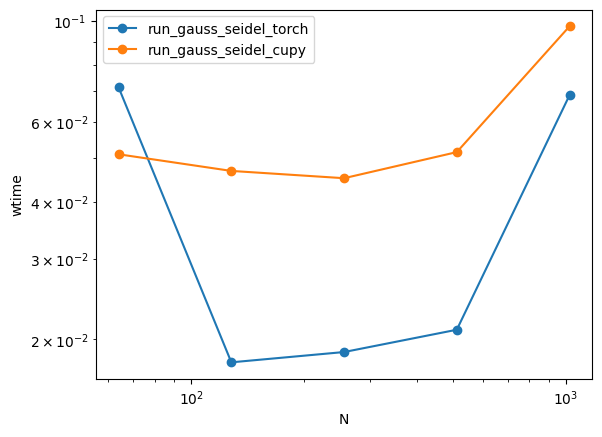

In [7]:
if __name__ == '__main__':
    run_function_as_experiment(run_gauss_seidel_torch,func=gauss_seidel_torch)
    run_function_as_experiment(run_gauss_seidel_cupy,func=gauss_seidel_cupy)

    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("N")
    plt.ylabel("wtime")
    plt.legend()

    plt.show()

# Porting Results to HDF5 File
Here, we ported the results obtained by running the PyTorch and the CuPy versions of the algorithm on a 1024 x 1024 grid for 50 iterations to an HDF5 file. This file has been uploaded in the repository by the same name. The HDF5 File having the results of the same configuration but for the original and cython implementations (_without the Jacobi numerical scheme_) can be found in the repo as well under the name `matrix_python_cython.hdf5`. That was generated using the `save_1024_grid_hdf5` function in the `poisson_solver.py` file. 

In [ ]:
f = h5py.File("matrix_gpu.hdf5", "w")
torch_1024 = run_gauss_seidel_torch(gauss_seidel_torch, 1024, 50)
cupy_1024 = run_gauss_seidel_cupy(gauss_seidel_cupy, 1024, 50)
f["/1024/cupy"] = cupy.asnumpy(cupy_1024)
f["/1024/torch"] = torch_1024.cpu().detach().numpy()
f.close()